In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
features_col = ['Arflux','Fflux',
            'ArExponent','FrExponent',
            'yield_at_zero1','yield_at_zero2','yield_at_zero3',
            'yield_max1','yield_max2','yield_max3',
            'theta_max1','theta_max2','theta_max3','mizk',
            'p1','p2','p3','p4','p5']

In [3]:
def get_time(filename):
    values = filename.split("_")
    for t_value in values:
        if t_value in ['2','4','6','8','10','12']:
            # print(t_value)
            return int(t_value)
    return None

In [4]:
def get_total():
    total = 0
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles'), key=len):
        total+=len(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{file}')) 
    return total

In [6]:
df_final = pd.DataFrame()
# valid_df_final = pd.DataFrame()
test_df_final = pd.DataFrame()

test_file_num = 0
turn = 1

total  = get_total()

test_size = int(0.2*total)

for folder in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles'), key=len):

    # sorting file acc to len so that t= 10,12 gets to its original pos
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}'), key=len):

        input_values = file.split('_')[1:-3]
        input_values = [float(item) for item in input_values]
        if(turn <= 8):
            df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = df[df['FitRadius_Avg']==0].index
            df = df.drop(zero_values_row_index)
            indexes_of_not_silicon = df[df['Z']>=0.000].index
            df = df.drop(indexes_of_not_silicon)

            df['Z'] = df['Z'].apply(lambda x: round(x,7))

            new_df = pd.DataFrame()

            new_df['Z'] = df['Z'][::5]
            new_df['avg fitradius'] = df['FitRadius_Avg'][::5]
            new_df['time'] = get_time(file)

            for i in range(len(input_values)):
                    # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            df_final = pd.concat([df_final,new_df])   
            turn+=1

        else:
            test_file_num+=1

            test_df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}/{file}')

            #dropping rows with zero valies in it
            zero_values_row_index = test_df[test_df['FitRadius_Avg']==0].index
            test_df = test_df.drop(zero_values_row_index)
            indexes_of_not_silicon = test_df[test_df['Z']>=0.000].index
            test_df = test_df.drop(indexes_of_not_silicon)

            test_df['Z'] = test_df['Z'].apply(lambda x: round(x,7))

            new_df = pd.DataFrame()

            new_df['Z'] = test_df['Z'].iloc[::5]
            new_df['avg fitradius'] = test_df['FitRadius_Avg'][::5]
            new_df['time'] = get_time(file)

            for i in range(len(input_values)):
                    # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            test_df_final = pd.concat([test_df_final,new_df])    

            if turn==9: turn+=1
            else: turn = 1

In [7]:
test_df_final.shape

(59838, 22)

<Axes: >

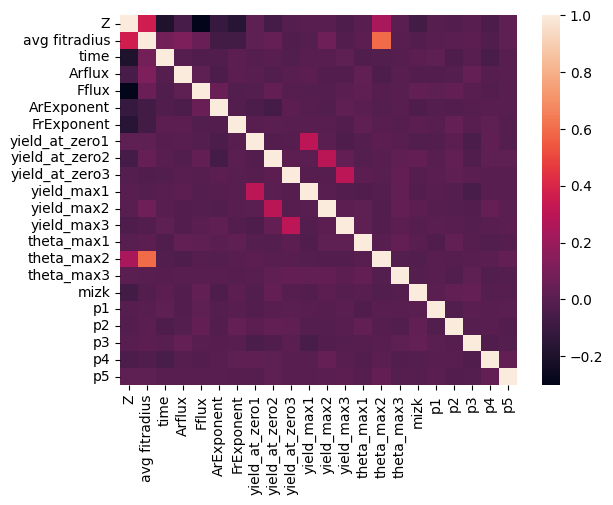

In [8]:
sns.heatmap(df_final.corr())

In [9]:
def relative_mean_absolute_error(y_true, y_pred):
    
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate Mean Absolute Error (MAE)
    rmae = np.mean((np.abs(y_true - y_pred))/y_true)
    
    return rmae

def custom_mse(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def custom_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [10]:
x_train = df_final.loc[:, ~df_final.columns.isin(['avg fitradius'])] #removing time as well right now
y_train = df_final[['avg fitradius']]
# x_valid = valid_df_final.loc[:, ~valid_df_final.columns.isin(['Z','avg fitradius'])]
# y_valid = valid_df_final[['Z']]
y_test = test_df_final[['avg fitradius']]
x_test = test_df_final.drop(['avg fitradius'], axis=1)

In [11]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
X_scale_arr = scaler_x_train.fit_transform(x_train)
df_scaledX = pd.DataFrame(X_scale_arr, columns=x_train.columns)

scaler_y_train = StandardScaler()
y_scale_arr = scaler_y_train.fit_transform(y_train)
df_scaledy = pd.DataFrame(y_scale_arr, columns=y_train.columns)

# scaler_x_valid = StandardScaler()
# X_scale_v_arr = scaler_x_valid.fit_transform(x_valid)
# df_scaledX_v = pd.DataFrame(X_scale_v_arr, columns=x_test.columns)

# scaler_y_valid = StandardScaler()
# y_scale_v_arr = scaler_y_valid.fit_transform(y_valid)
# df_scaledy_v = pd.DataFrame(y_scale_v_arr, columns=y_test.columns)

scaler_x_test = StandardScaler()
X_scale_t_arr = scaler_x_test.fit_transform(x_test)
df_scaledX_t = pd.DataFrame(X_scale_t_arr, columns=x_test.columns)

scaler_y_test = StandardScaler()
y_scale_t_arr = scaler_y_test.fit_transform(y_test)
df_scaledy_t = pd.DataFrame(y_scale_t_arr, columns=y_test.columns)


X_train_scaled_reshaped = X_scale_arr.reshape(X_scale_arr.shape[0],1,X_scale_arr.shape[1])
X_train_scaled_reshaped.shape

X_test_scaled_reshaped = X_scale_t_arr.reshape(X_scale_t_arr.shape[0],1,X_scale_t_arr.shape[1])
X_test_scaled_reshaped.shape

# X_valid_scaled_reshaped = X_scale_v_arr.reshape(X_scale_v_arr.shape[0],1,X_scale_v_arr.shape[1])
# X_valid_scaled_reshaped.shape

(59838, 1, 21)

In [12]:
y_train

,avg fitradius
969,0.018700
974,0.025804
979,0.028005
984,0.028414
989,0.027778
...,...
977,0.029624
982,0.029197
987,0.028768
992,0.028312


In [13]:
y_train_scale = y_train*1000000
y_test_scale = y_test*1000000

In [14]:
indexes = []
curr_Arflux = x_test['Arflux'].to_list()[0]
counter = 0
for  index, row in x_test.iterrows():
    if(row['Arflux']!=curr_Arflux):
        indexes.append(counter)
        curr_Arflux = row['Arflux']
    counter+=1

In [14]:
# #LSTM
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from keras.callbacks import EarlyStopping


# def create_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(200, input_shape=input_shape, return_sequences=True, activation='relu'))
#     model.add(LSTM(100,  dropout=0.5, return_sequences=True, activation='relu'))
#     model.add(LSTM(50,dropout=0.4, return_sequences=True, activation='relu'))
#     model.add(LSTM(10, activation='relu'))
#     model.add(Dense(1))  # Assuming 2 target variables
#     model.compile(optimizer='adam', loss='mae')
#     return model

# model = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, verbose=1)
# history = model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_scaled_reshaped, y_scale_t_arr), 
#                     callbacks=[early_stopping]
#                     )

# # val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# # print(f'Validation Loss: {val_loss}')

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

In [ ]:
# # Evaluate the model
# mae = custom_mse(y_scale_t_arr, y_pred)
# r2_score_c= custom_r2(y_scale_t_arr, y_pred)

# print("Mean Abs Error (MAE):", mae)
# print("R2 score: ", r2_score_c)

Mean Abs Error (MAE): 0.1511350374794804
R2 score:  0.915767533607459


In [ ]:
# predictions = scaler_y_test.inverse_transform(y_pred)
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],X_test_scaled_reshaped.shape[2]))

In [ ]:
# index = 0
# count = 1
# for i in indexes:
#     plt.figure()
#     plt.xlim(0,0.1)
#     plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
#     plt.scatter(predictions[index:i,0],x_test_plot[index:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1

For t = 12, reversing indexes

In [ ]:
# rev_index = indexes[::-1]
# index = len(x_test)
# count = 1
# for i in rev_index:
#     plt.figure()
#     plt.xlim(0,0.1)
#     plt.scatter(y_test.iloc[i:index,0],x_test.iloc[i:index,0], c='red',label=f'True values')
#     plt.scatter(predictions[i:index,0], x_test_plot[i:index,0],c='blue',label=f'Predicted values')
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1

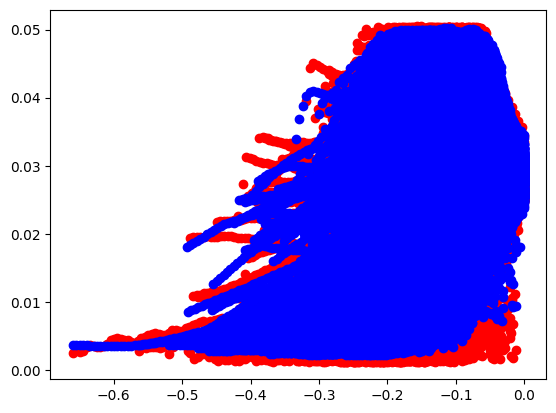

In [ ]:
# plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
# plt.scatter(x_test_plot[:,0],predictions[:,0],c='blue',label=f'Predicted values')

In [ ]:
# #CNN with LSTM
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed, GlobalAveragePooling1D

# def create_conv_lstm_model(input_shape, num_classes):
#     model = tf.keras.Sequential()
    
#     # Convolutional layers
#     model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
#     model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=1, activation='relu'))
    
#     model.add(tf.keras.layers.GlobalAveragePooling1D())
#     model.add(tf.keras.layers.BatchNormalization())
    
#     # Flatten before feeding into LSTM
#     model.add(tf.keras.layers.Reshape((1, 20)))

#     # LSTM layers
#     model.add(tf.keras.layers.LSTM(200, return_sequences=True))
#     model.add(tf.keras.layers.LSTM(128))
    
#     # Fully connected layers
#     # model.add(tf.keras.layers.Dense(64, activation='relu'))
#     # model.add(tf.keras.layers.Dense(32, activation='relu'))
#     model.add(tf.keras.layers.Dense(num_classes))

#     # Compile the model
#     model.compile(optimizer='adam', loss='mae')
#     return model

# model = create_conv_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]), num_classes = 1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, verbose=1)
# history = model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_scaled_reshaped, y_scale_t_arr), 
#                     callbacks=[early_stopping]
#                     )

# # val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# # print(f'Validation Loss: {val_loss}')

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

Epoch 1/50
3828/3828 [==============================] - 41s 10ms/step - loss: 0.2835 - val_loss: 0.2307
Epoch 2/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1922 - val_loss: 0.1921
Epoch 3/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1698 - val_loss: 0.1615
Epoch 4/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1564 - val_loss: 0.1686
Epoch 5/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1478 - val_loss: 0.1562
Epoch 6/50
3828/3828 [==============================] - 36s 10ms/step - loss: 0.1402 - val_loss: 0.1478
Epoch 7/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1348 - val_loss: 0.1454
Epoch 8/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1291 - val_loss: 0.1533
Epoch 9/50
3828/3828 [==============================] - 32s 8ms/step - loss: 0.1259 - val_loss: 0.1494
Epoch 9: early stopping
1870/1870 [==============================] - 5s

In [ ]:
# predictions = scaler_y_test.inverse_transform(y_pred)
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],X_test_scaled_reshaped.shape[2]))

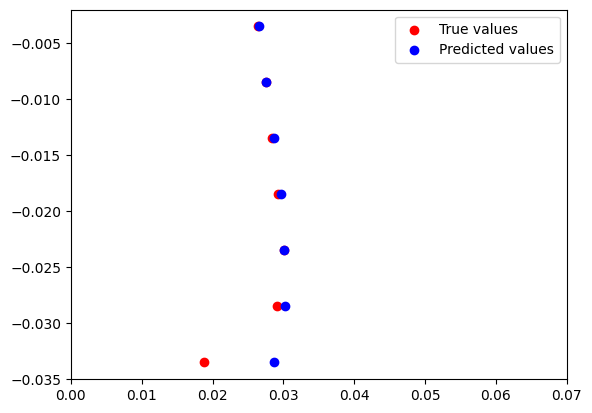

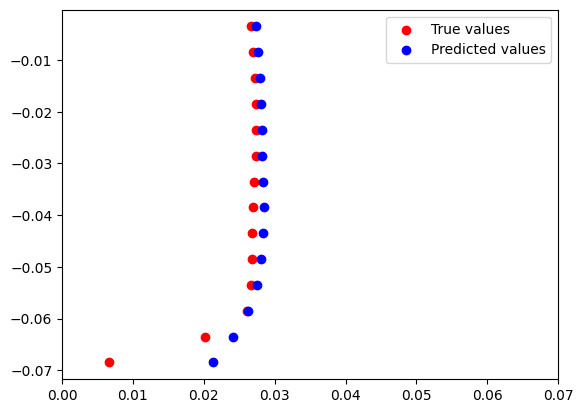

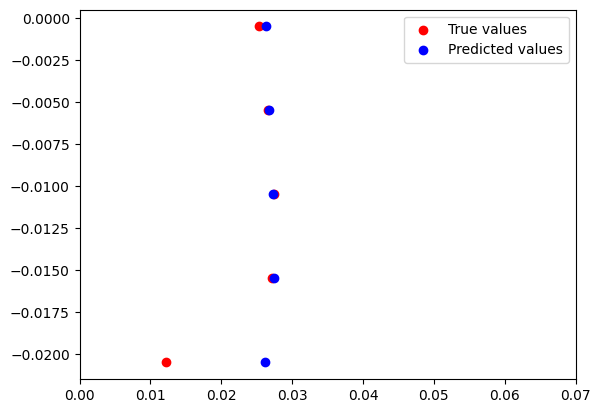

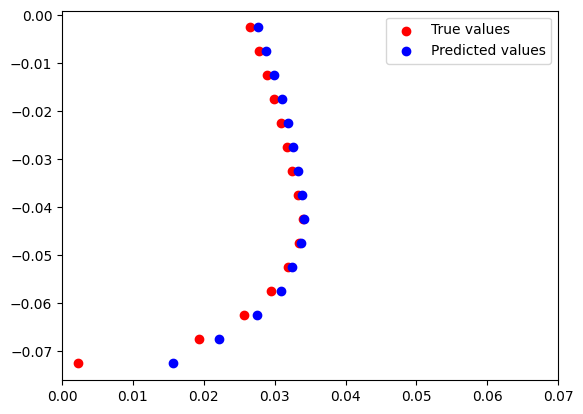

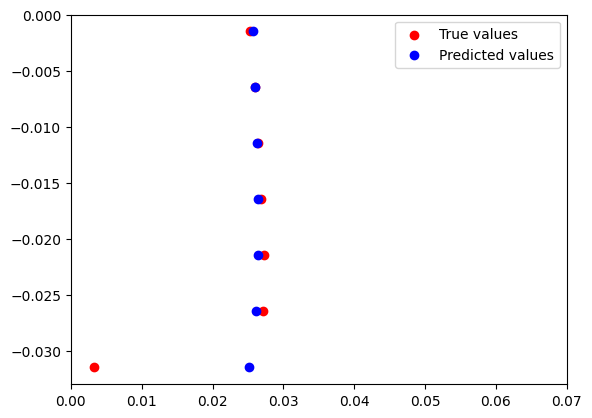

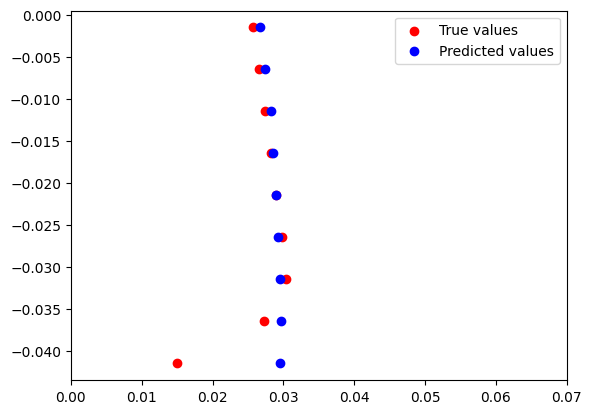

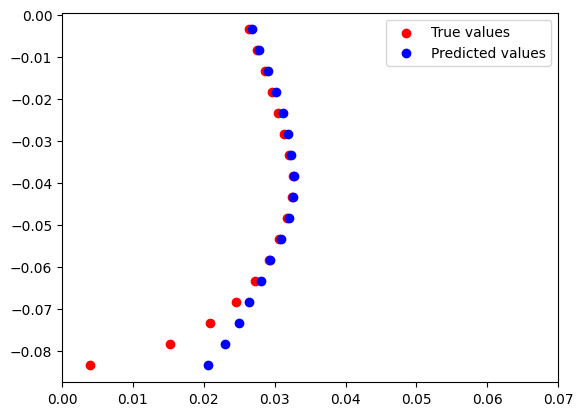

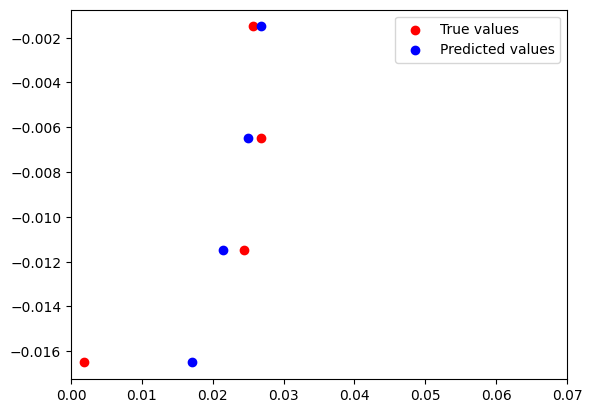

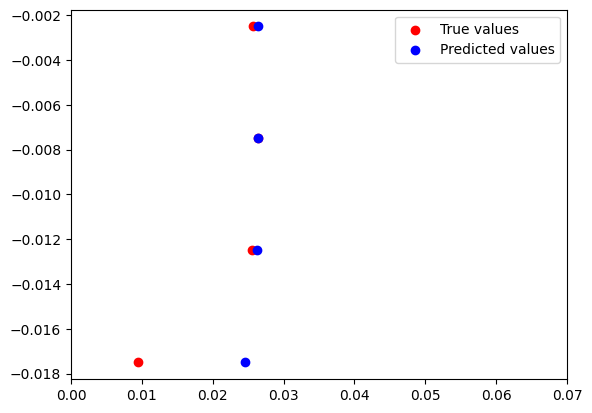

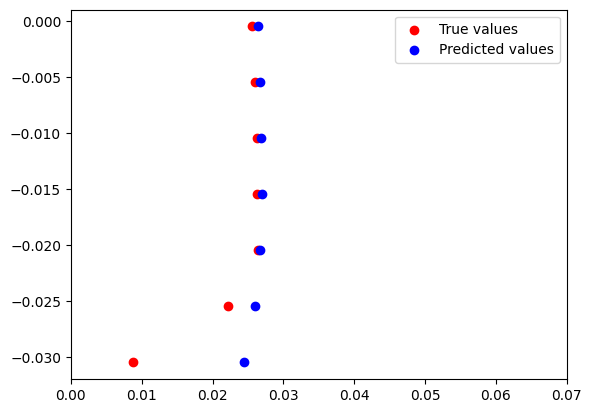

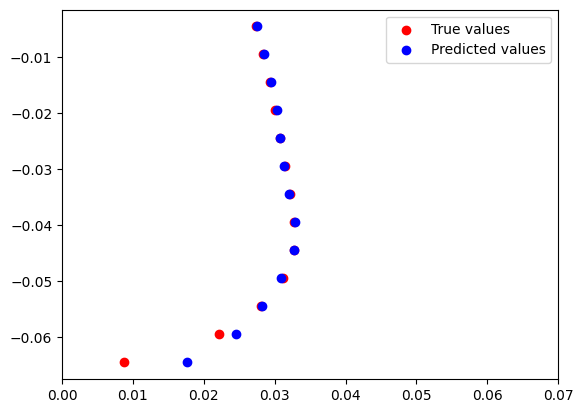

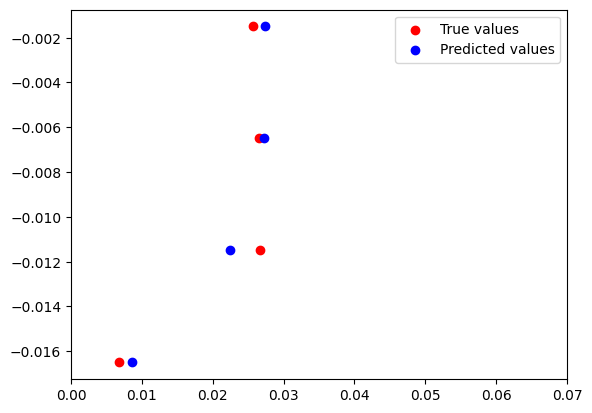

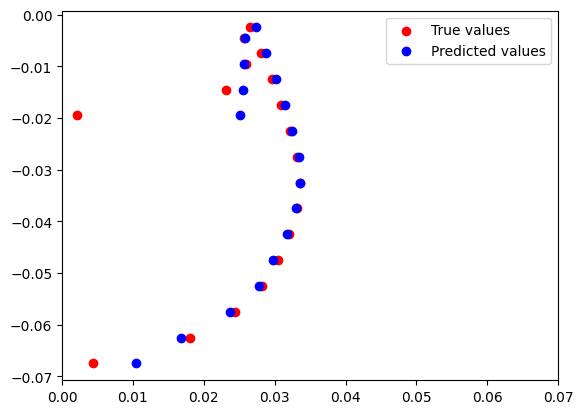

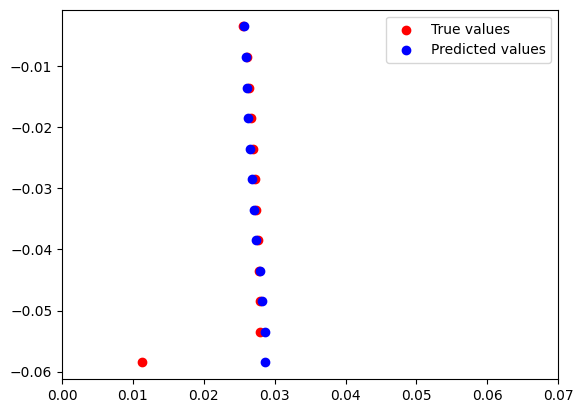

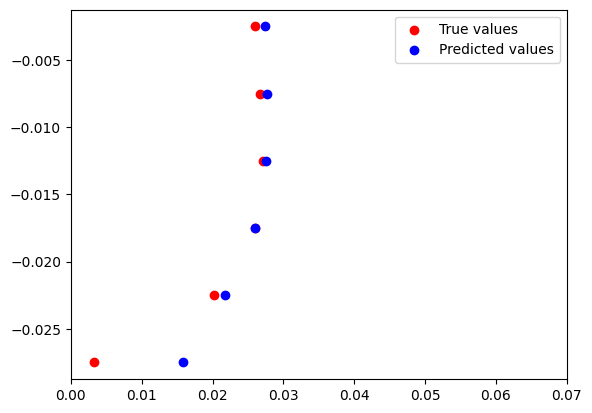


t=12



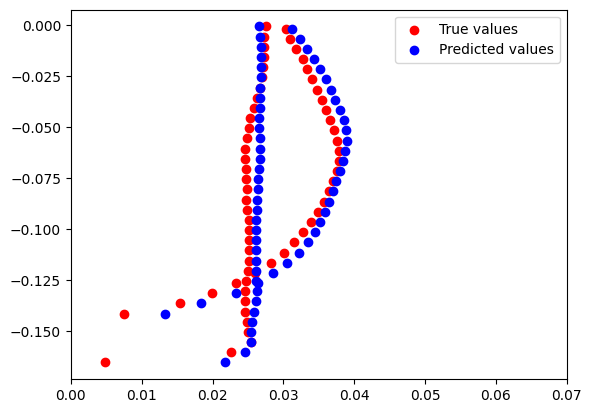

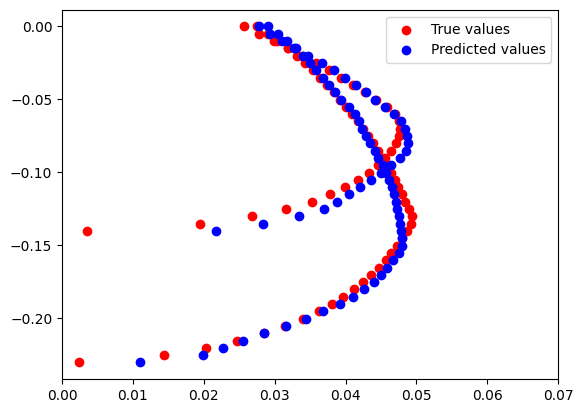

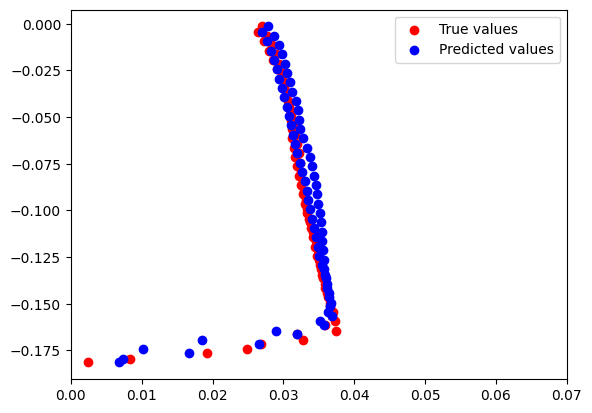

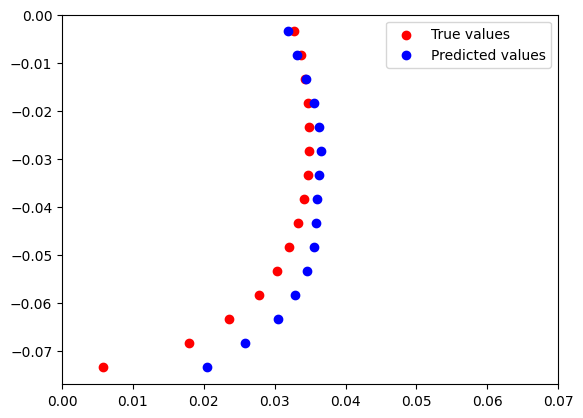

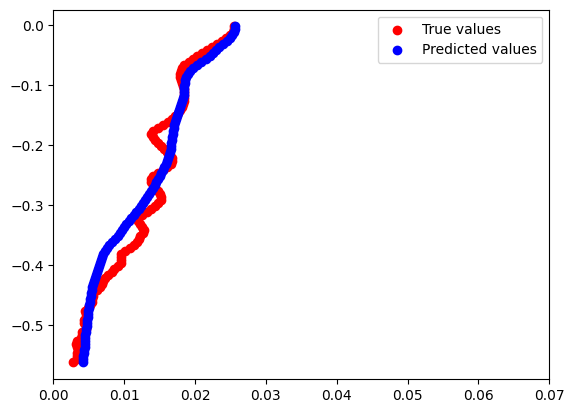

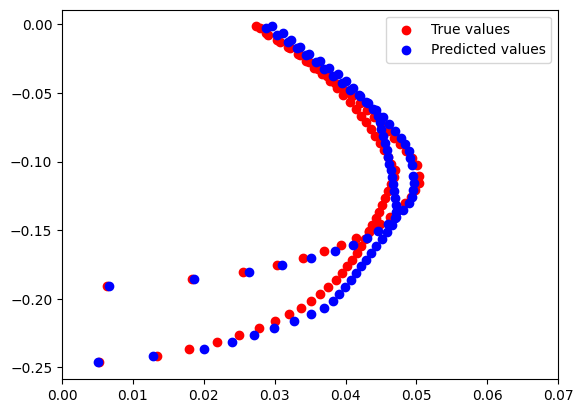

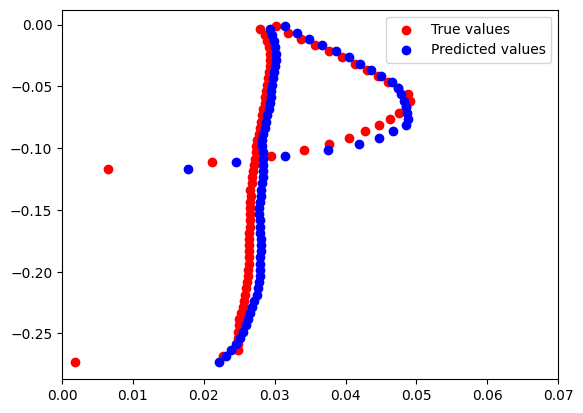

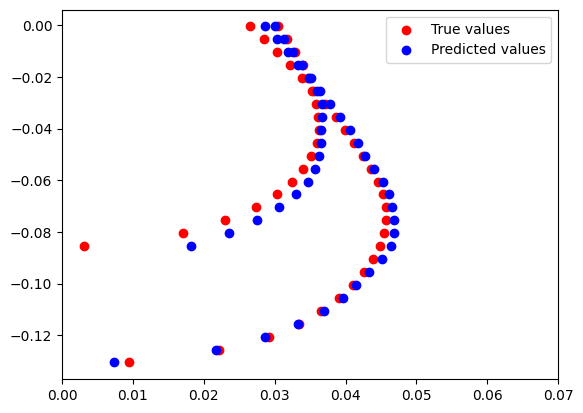

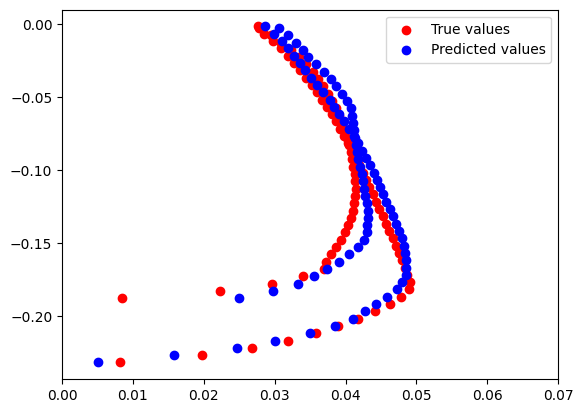

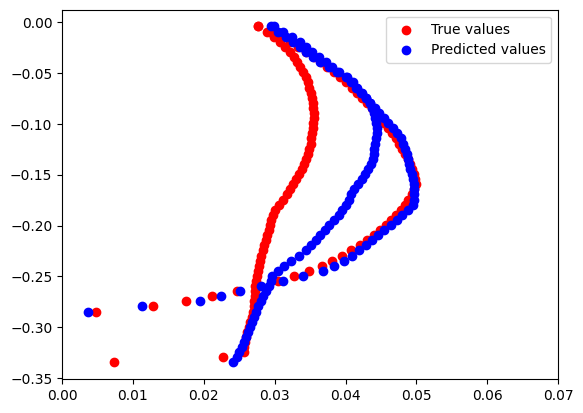

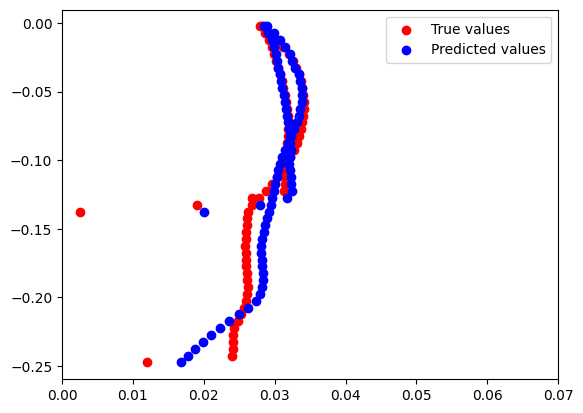

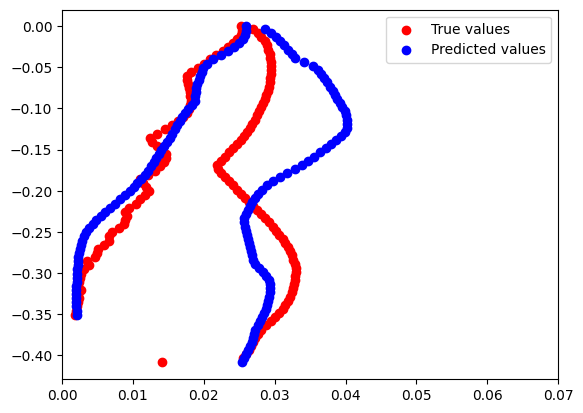

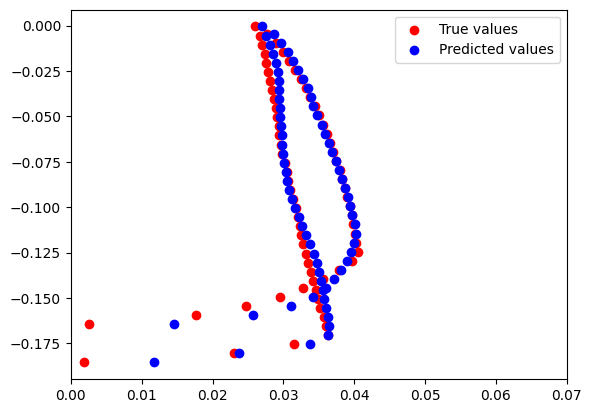

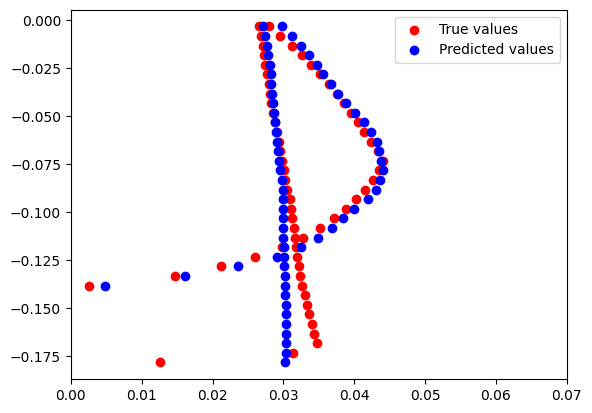

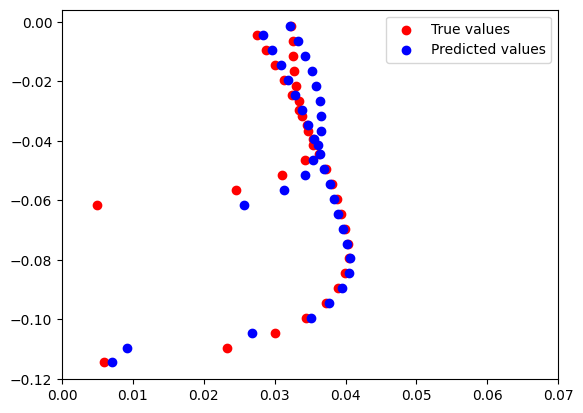

In [ ]:
# index = 0
# count = 1
# for i in indexes:
#     plt.figure()
#     plt.xlim(0,0.07)
#     plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
#     plt.scatter(predictions[index:i,0],x_test_plot[index:i,0],c='blue',label=f'Predicted values')
#     plt.legend()
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1
# print('\nt=12\n')
# rev_index = indexes[::-1]
# index = len(x_test)
# count = 1
# for i in rev_index:
#     plt.figure()
#     plt.xlim(0,0.07)
#     plt.scatter(y_test.iloc[i:index,0],x_test.iloc[i:index,0], c='red',label=f'True values')
#     plt.scatter(predictions[i:index,0], x_test_plot[i:index,0],c='blue',label=f'Predicted values')
#     plt.legend()
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1

GNN

In [ ]:
# import numpy as np
# import tensorflow as tf
# from spektral.data import Dataset, Graph
# from spektral.layers import GCNConv, GlobalAvgPool, GlobalMaxPool
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense

# # Assuming X_train_scaled_reshaped, X_test_scaled_reshaped, y_scale_arr, and y_test are available and formatted as required

# # Sample data preparation
# num_nodes = X_train_scaled_reshaped.shape[1]
# num_features = X_train_scaled_reshaped.shape[2]
# num_classes = y_scale_arr.shape[1]

# # Generate adjacency matrix (modify to reflect your actual graph structure)
# # This is a simple example, consider using a sparse matrix for larger graphs
# #so using zeroes instead of ones
# A = np.zeros((num_nodes, num_nodes)) + np.eye(num_nodes)

# # Define a custom Spektral dataset
# class MyDataset(Dataset):
#     def __init__(self, X, A, y, **kwargs):
#         self.X = X
#         self.A = A
#         self.y = y
#         super().__init__(**kwargs)

#     def read(self):
#         graphs = []
#         for i in range(len(self.X)):
#             x = self.X[i]
#             a = self.A
#             y = self.y[i]
#             graphs.append(Graph(x=x, a=a, y=y))
#         return graphs

# # Create datasets
# train_dataset = MyDataset(X_train_scaled_reshaped, A, y_scale_arr)
# test_dataset = MyDataset(X_test_scaled_reshaped, A, y_scale_t_arr)

# # Define the GNN model using Spektral
# def create_gnn_model(input_shape, output_shape):
#     X_in = Input(shape=input_shape, name='node_features')
#     A_in = Input(shape=(num_nodes,), sparse=True, name='adjacency_matrix')

#     # Graph Convolutional Layer
#     x = GCNConv(200,activation='relu')([X_in, A_in])
#     x = GlobalMaxPool()(x)
#     # x = GCNConv(50)([x])
#     # x = GlobalMaxPool()(x)

#     # Fully connected layers
#     x = Dense(28)(x)
#     outputs = Dense(output_shape)(x)

#     return Model(inputs=[X_in, A_in], outputs=outputs)

# # Create and compile the model
# input_shape = (num_nodes, num_features)
# output_shape = y_scale_arr.shape[1]
# model = create_gnn_model(input_shape, output_shape)
# model.compile(optimizer='adam', loss='mae')

# # Convert the dataset to TensorFlow data format
# def dataset_to_tfdata(dataset):
#     def generator():
#         for graph in dataset:
#             yield (graph.x, graph.a), graph.y
#     return tf.data.Dataset.from_generator(
#         generator,
#         output_signature=(
#             (tf.TensorSpec(shape=(num_nodes, num_features), dtype=tf.float32),
#              tf.TensorSpec(shape=(num_nodes, num_nodes), dtype=tf.float32)),
#             tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
#         )
#     )

# # Create TensorFlow datasets
# train_tfdata = dataset_to_tfdata(train_dataset).batch(1)
# test_tfdata = dataset_to_tfdata(test_dataset).batch(1)

# # Train the model
# model.fit(train_tfdata, epochs=100)

# # Evaluate the model
# loss = model.evaluate(test_tfdata)
# print(f"Test Loss: {loss}")

# # Predict on the test set
# y_pred_gnn = model.predict(test_tfdata)


Epoch 1/100
1726/1726 [==============================] - 11s 4ms/step - loss: 0.4618
Epoch 2/100
1726/1726 [==============================] - 6s 4ms/step - loss: 0.3422
Epoch 3/100
1726/1726 [==============================] - 7s 4ms/step - loss: 0.3036
Epoch 4/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2818
Epoch 5/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2660
Epoch 6/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2540
Epoch 7/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2418
Epoch 8/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2362
Epoch 9/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2288
Epoch 10/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2197
Epoch 11/100
1726/1726 [==============================] - 6s 3ms/step - loss: 0.2147
Epoch 12/100
1726/1726 [==============================] - 6s 3ms/step - l

In [ ]:
# predictions = scaler_y_test.inverse_transform(y_pred_gnn)

In [ ]:
# # Evaluate the model
# mae = custom_mse(y_scale_t_arr, y_pred_gnn)
# r2_score_c= custom_r2(y_scale_t_arr, y_pred_gnn)

# print("Mean Abs Error (MAE):", mae)
# print("R2 score: ", r2_score_c)

In [ ]:

# plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
# plt.scatter(x_test_plot[:,0],predictions[:,0],c='blue',label=f'Predicted values')

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(8192, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(4096, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(2048, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(1024, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(512, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(256, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(SimpleRNN(128, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(SimpleRNN(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Assuming 1 target variable
    model.compile(optimizer='adam', loss='mape')
    return model

# Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 3D arrays
# and the input shape is (time_steps, number of features)
input_shape = (X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])

model = create_rnn_model(input_shape=input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, verbose=1)

history = model.fit(X_train_scaled_reshaped, y_train_scale, epochs=500, batch_size=256, verbose=1, 
                    validation_data=(X_test_scaled_reshaped, y_test_scale), 
                    # callbacks=[early_stopping]
                    )

# Predict on the test set
y_pred = model.predict(X_test_scaled_reshaped)

print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

Epoch 1/500
957/957 ━━━━━━━━━━━━━━━━━━━━ 2469s 3s/step - loss: 40.0818 - val_loss: 23.4621
Epoch 2/500
957/957 ━━━━━━━━━━━━━━━━━━━━ 2244s 2s/step - loss: 20.6892 - val_loss: 21.8450
Epoch 3/500
957/957 ━━━━━━━━━━━━━━━━━━━━ 2215s 2s/step - loss: 17.7836 - val_loss: 19.9029
Epoch 4/500
479/957 ━━━━━━━━━━━━━━━━━━━━ 17:02 2s/step - loss: 16.9120

KeyboardInterrupt: 

In [25]:
y_pred = model.predict(X_test_scaled_reshaped)

print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step
Loss: 0.14525079493356322


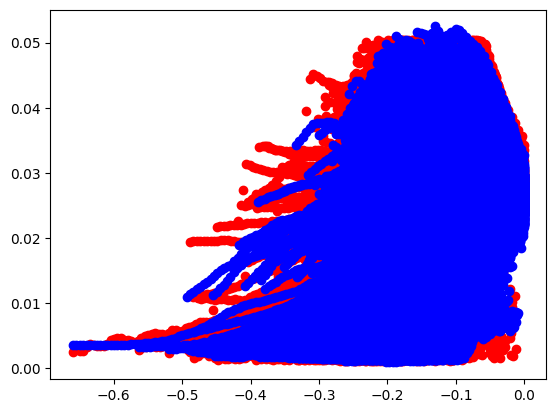

In [19]:
# plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
# plt.scatter(x_test.iloc[:,0],y_pred[:,0]/1000000,c='blue',label=f'Predicted values')

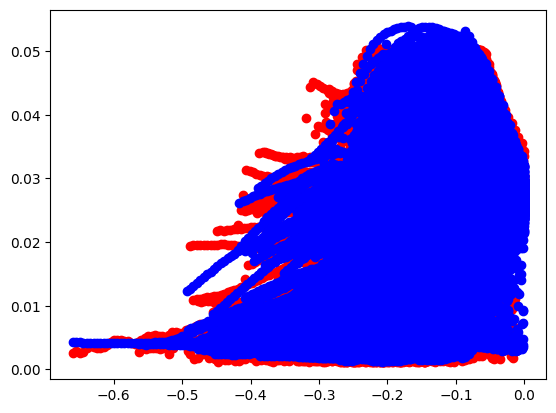

In [26]:
plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
plt.scatter(x_test.iloc[:,0],y_pred[:,0]/1000000,c='blue',label=f'Predicted values')

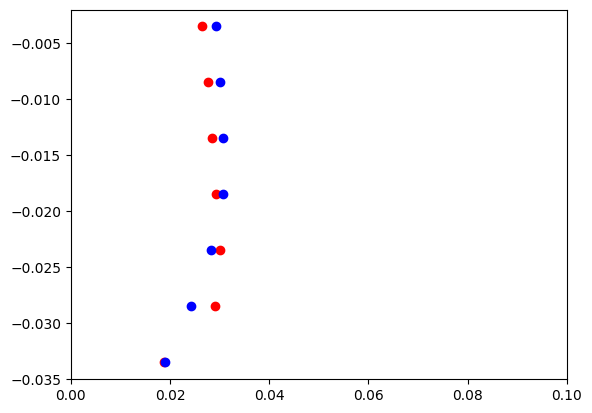

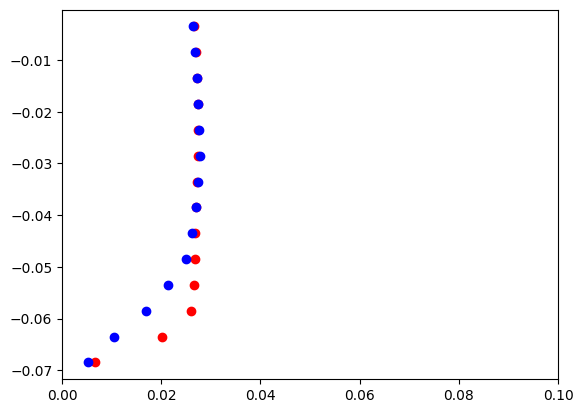

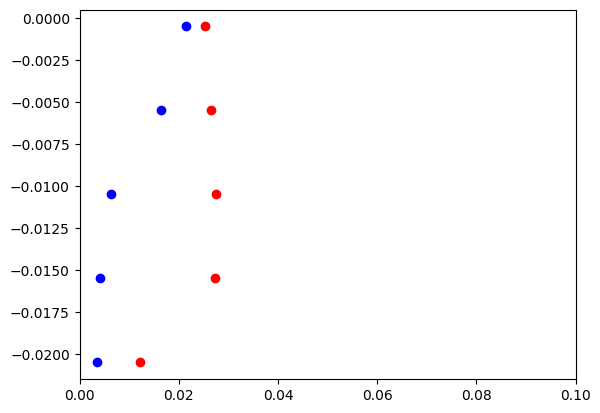

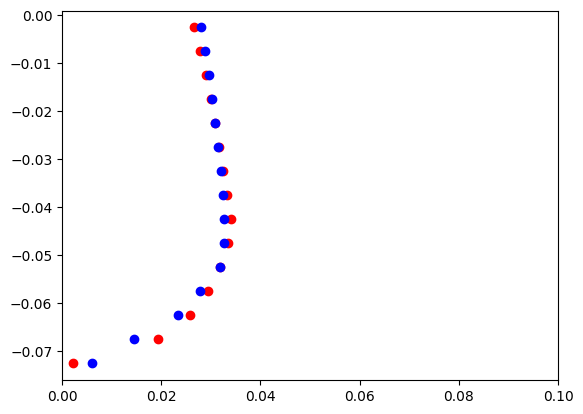

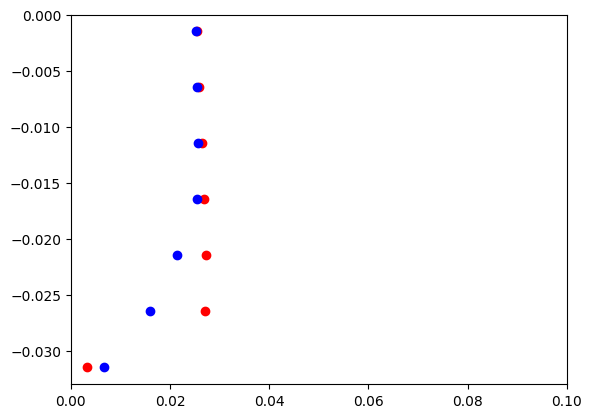

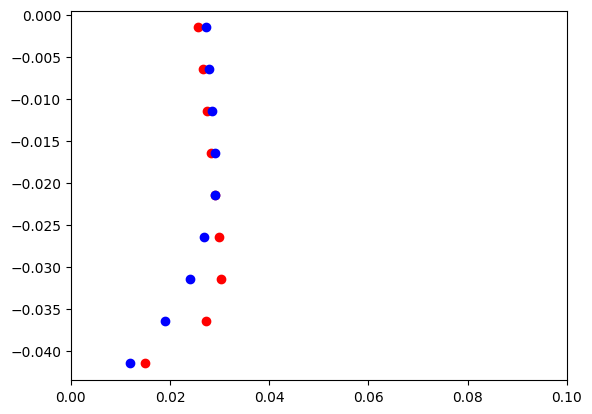

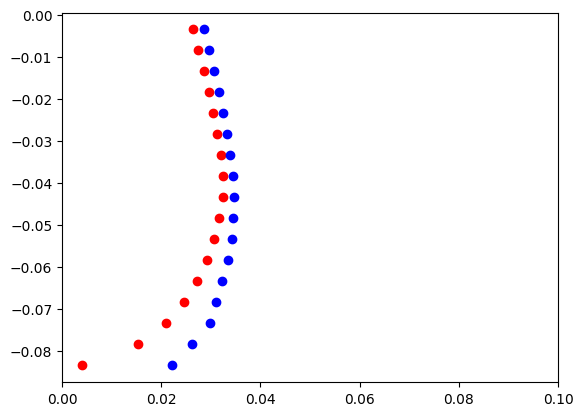

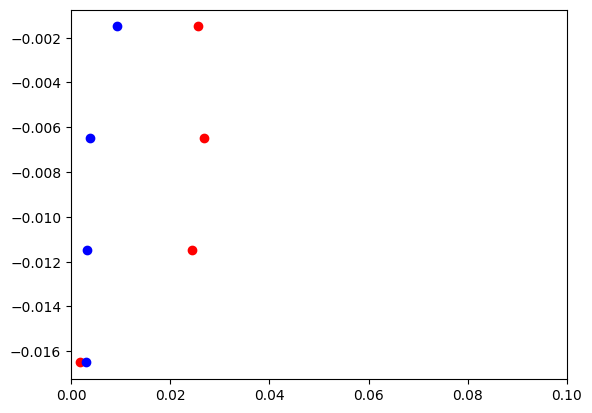

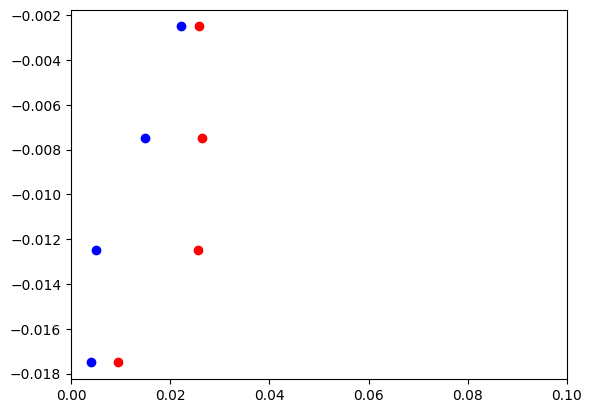

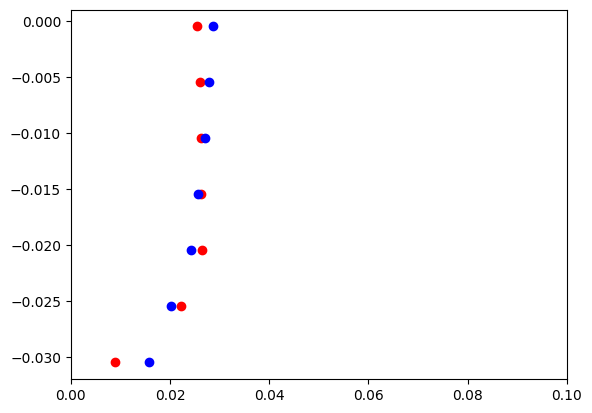

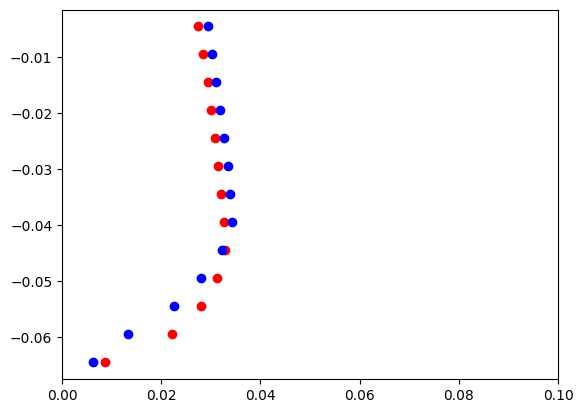

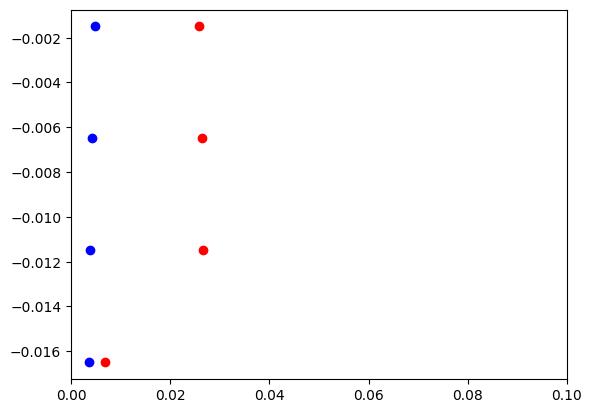

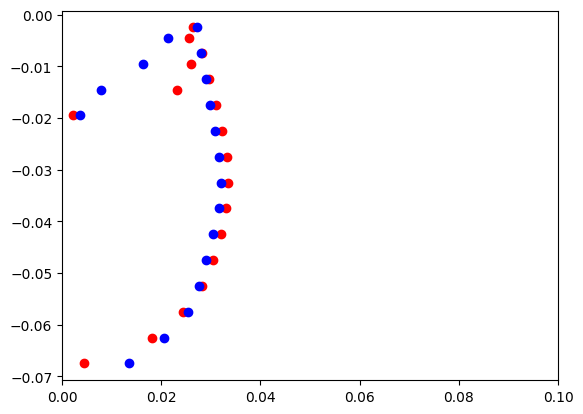

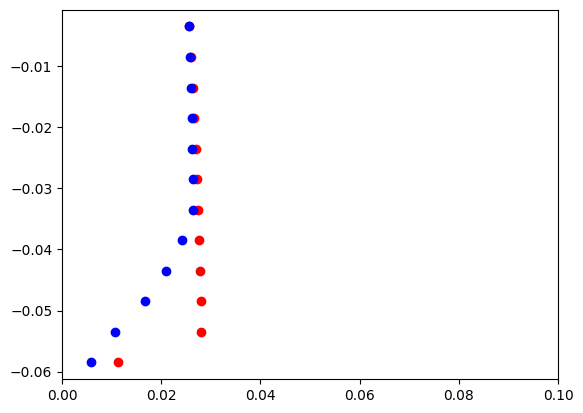

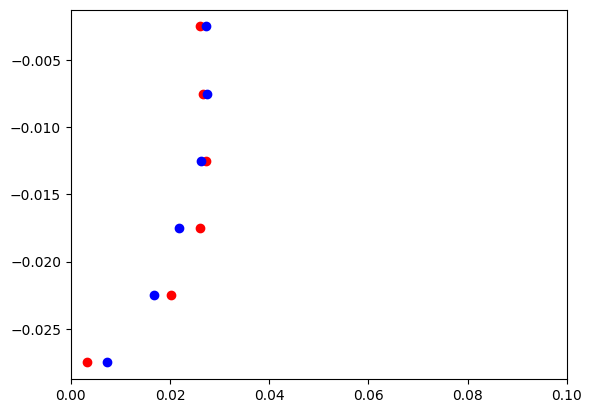

In [27]:
index = 0
count = 1
for i in indexes:
    plt.figure()
    plt.xlim(0,0.1)
    plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
    plt.scatter(y_pred[index:i,0]/1000000,x_test.iloc[index:i,0],c='blue',label=f'Predicted values')
    plt.show()
    index = i
    if count==15: break
    count+=1

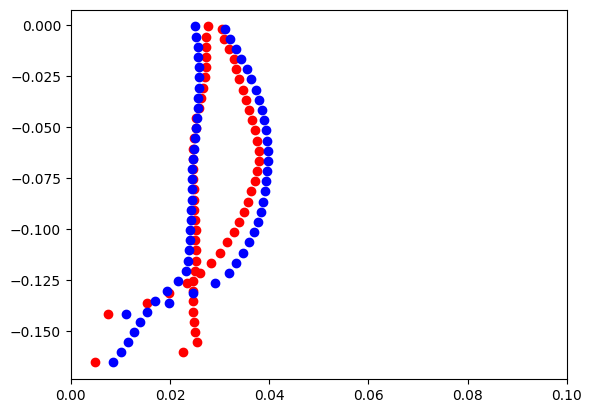

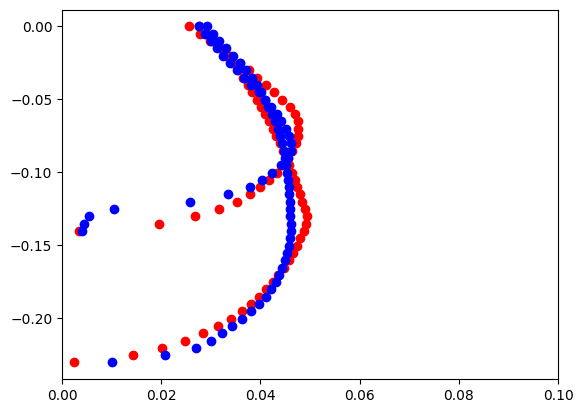

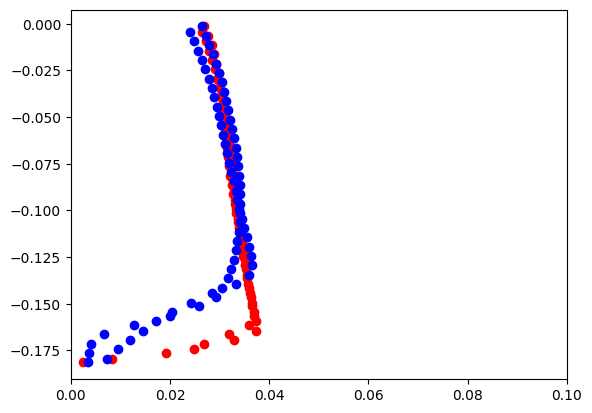

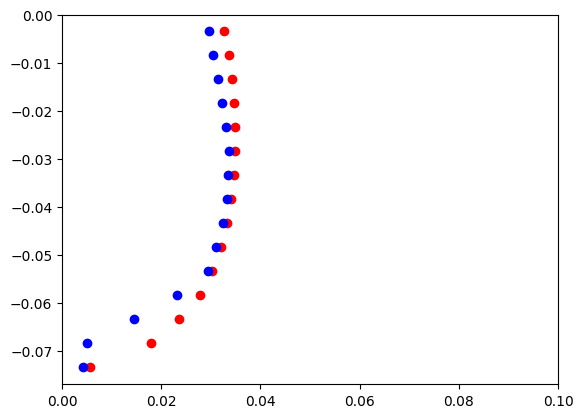

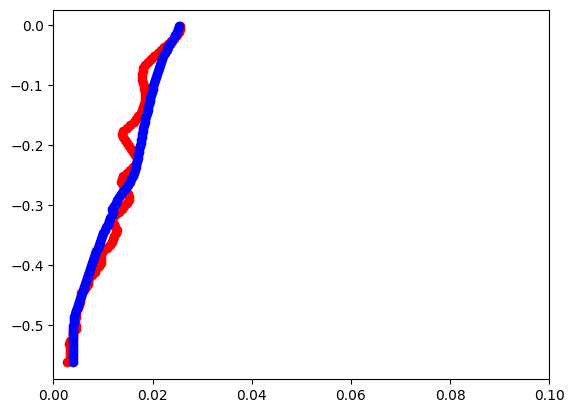

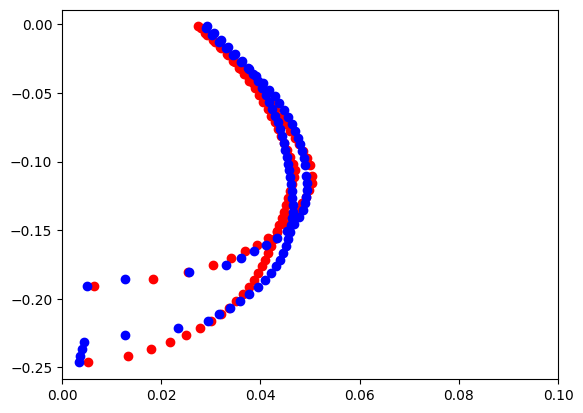

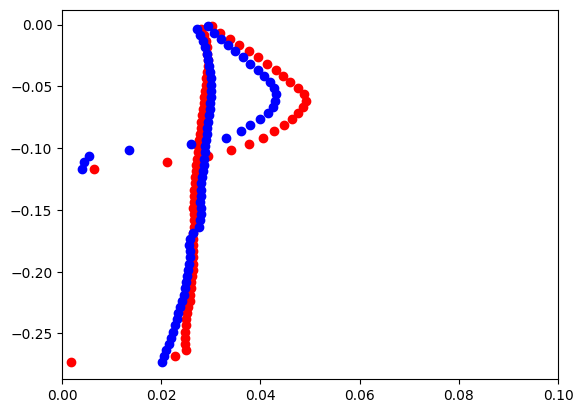

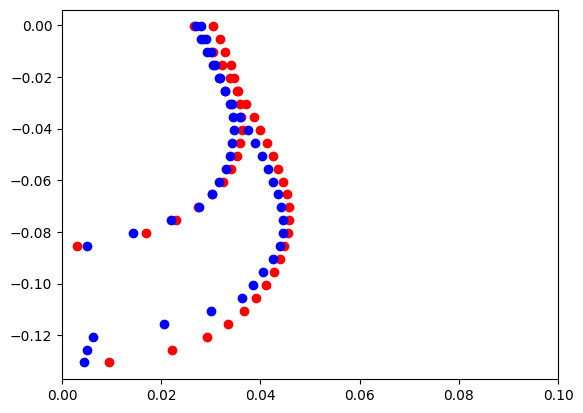

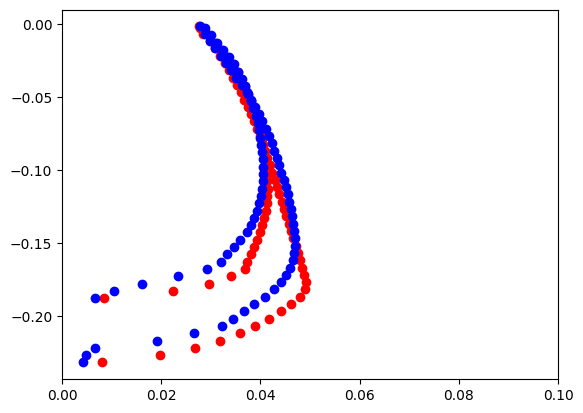

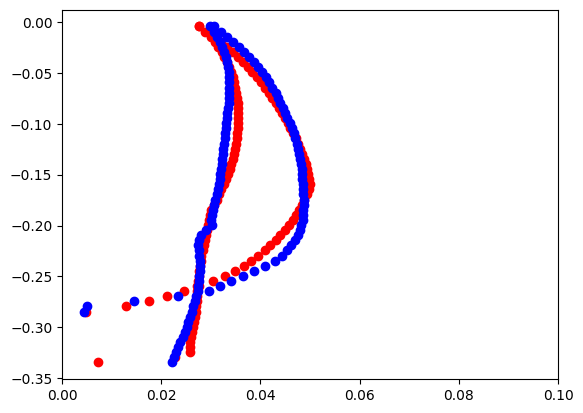

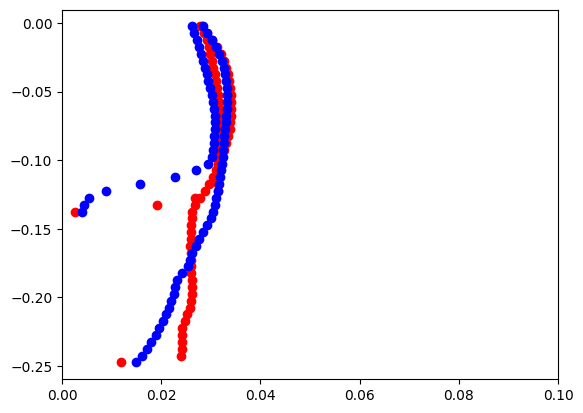

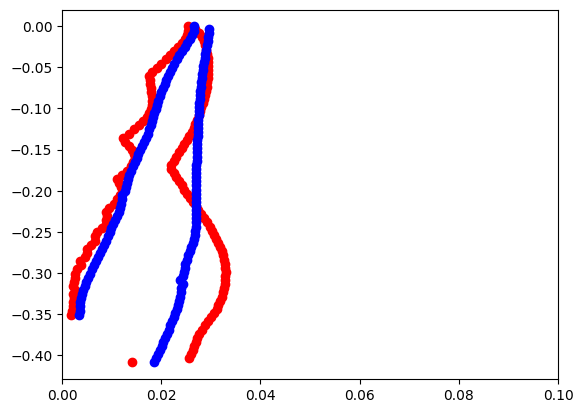

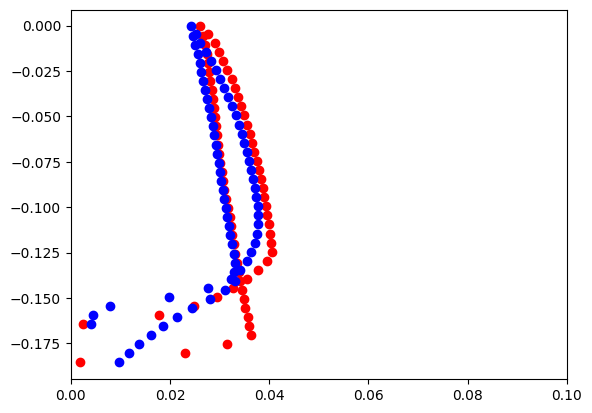

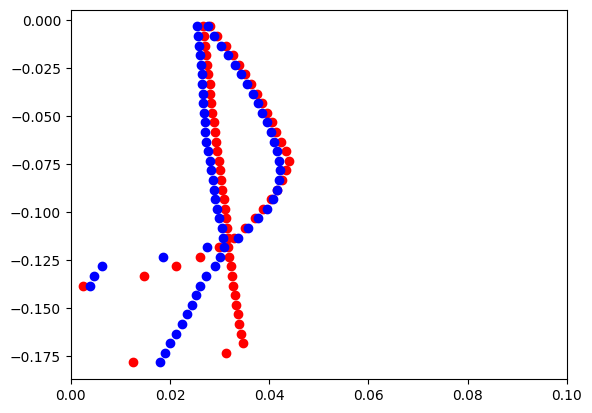

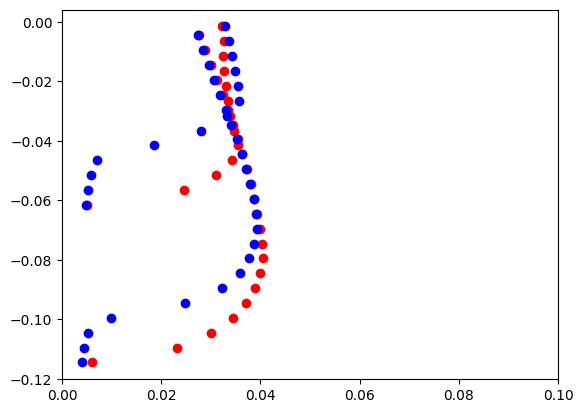

In [28]:
rev_index = indexes[::-1]
index = len(x_test)
count = 1
for i in rev_index:
    plt.figure()
    plt.xlim(0,0.1)
    plt.scatter(y_test.iloc[i:index,0],x_test.iloc[i:index,0], c='red',label=f'True values')
    plt.scatter(y_pred[i:index,0]/1000000, x_test.iloc[i:index,0],c='blue',label=f'Predicted values')
    plt.show()
    index = i
    if count==15: break
    count+=1